# IN25 - Validation of the radiosity simulation
This notebook generates plots for the internoise 2025 paper.
At each step, a different simulation validation step will be addressed.

In [1]:
import sparrowpy as sp
import pyfar as pf
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

base_dir = os.path.join(os.getcwd(), "resources")

## Form factor validation

### Patch energy conservation

In [37]:
radi = sp.DirectionalRadiosityFast.from_file(
                os.path.join(base_dir, "cube_simple.blend"),
                )
radi.bake_geometry()

ff_sum = np.sum(radi._form_factors_tilde, axis=0)[:,0,0]

for i,ffs in enumerate(ff_sum):
    print(f'\npatch {i}')
    print(f'    energy:     {ffs:.3f}')
    print(f'    rel error:  {100*(1-ffs)/1:.3f}%')

print(f'global rel error:  {100*(radi._n_patches-np.sum(ff_sum))/radi.n_patches:.3f}%')



patch 0
    energy:     0.995
    rel error:  0.509%

patch 1
    energy:     0.995
    rel error:  0.509%

patch 2
    energy:     0.995
    rel error:  0.509%

patch 3
    energy:     0.995
    rel error:  0.509%

patch 4
    energy:     0.995
    rel error:  0.509%

patch 5
    energy:     0.995
    rel error:  0.509%
global rel error:  0.509%


### Parallel facing patches

In [3]:
from sparrowpy.testing import exact_ff_solutions as solutions

def form_factor_parallel(width, height, distance):
    exact = solutions.parallel_patches(width, height, distance)

    patch_1 = sp.geometry.Polygon(
        points=[[0, 0, 0], [width, 0, 0], [width, 0, height], [0, 0, height]],
        normal=[0, 1, 0],
        up_vector=[1, 0, 0],
    )

    patch_2 = sp.geometry.Polygon(
        points=[
            [0, distance, 0],
            [0, distance, height],
            [width, distance, height],
            [width, distance, 0],
        ],
        normal=[0, -1, 0],
        up_vector=[1, 0, 0],
    )

    univ = sp.form_factor.universal.universal_form_factor(
                    source_pts=patch_1.pts,
                    source_normal=patch_1.normal,
                    source_area=patch_1.area,
                    receiver_pts=patch_2.pts,
                    receiver_normal=patch_2.normal)

    return exact,univ

d=1.
heights = np.arange(d/4,d*4,.1)
err_abs = np.zeros_like(heights)
err_rel = np.zeros_like(heights)

for i,h in enumerate(heights):
    tru, est = form_factor_parallel(h,h,d)
    err_abs[i] = est-tru
    err_rel[i] = 100*err_abs[i]/tru


C:\Users\jotag\Documents\dev\sparapy\sparrowpy\form_factor\universal.py:87: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  form_factor = integration.nusselt_integration(


C:\Users\jotag\AppData\Local\Temp\ipykernel_30656\1709284373.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


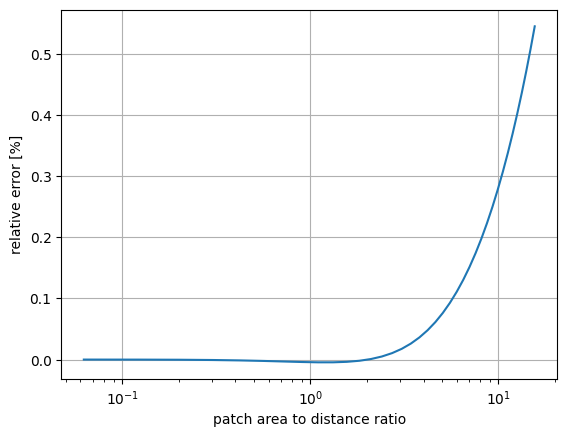

In [4]:
figure = plt.figure()
plt.semilogx(heights**2,err_rel)
plt.xlabel('patch area to distance ratio')
plt.ylabel('relative error [%]')
plt.grid()
figure.show()

### Perpendicular floating patches

In [5]:
def form_factor_perp_commonside(width, height, length):

    exact = solutions.perpendicular_patch_coincidentline(width, height, length)

    patch_1 = sp.geometry.Polygon(
        points=[
            [0, 0, 0],
            [0, length, 0],
            [0, length, height],
            [0, 0, height],
        ],
        normal=[1, 0, 0],
        up_vector=[1, 0, 0],
    )

    patch_2 = sp.geometry.Polygon(
        points=[[0, 0, 0],
                [width, 0, 0],
                [width, length, 0],
                [0, length, 0]],
        normal=[0, 0, 1],
        up_vector=[1, 0, 0],
    )

    univ = sp.form_factor.universal.universal_form_factor(
                    source_pts=patch_1.pts,
                    source_normal=patch_1.normal,
                    source_area=patch_1.area,
                    receiver_pts=patch_2.pts,
                    receiver_normal=patch_2.normal)

    return exact,univ


heights = np.arange(1/4,4,.1)
err_abs = np.zeros_like(heights)
err_rel = np.zeros_like(heights)

for i,h in enumerate(heights):
    tru, est = form_factor_parallel(h,h,1.)
    err_abs[i] = est-tru
    err_rel[i] = 100*err_abs[i]/tru

[-1.41598225e-05 -8.54644153e-05 -2.93817548e-04 -7.15561377e-04
 -1.37842589e-03 -2.23573039e-03 -3.16675735e-03 -3.99407440e-03
 -4.50668604e-03 -4.48184447e-03 -3.70236796e-03 -1.96877754e-03
  8.93276495e-04  5.02940702e-03  1.05557453e-02  1.75601879e-02
  2.61049057e-02  3.62295408e-02  4.79546614e-02  6.12851755e-02
  7.62135084e-02  9.27224329e-02  1.10787502e-01  1.30379076e-01
  1.51463971e-01  1.74006755e-01  1.97970745e-01  2.23318759e-01
  2.50013647e-01  2.78018669e-01  3.07297734e-01  3.37815549e-01
  3.69537688e-01  4.02430616e-01  4.36461675e-01  4.71599044e-01
  5.07811695e-01  5.45069336e-01]


C:\Users\jotag\AppData\Local\Temp\ipykernel_30656\3438777703.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


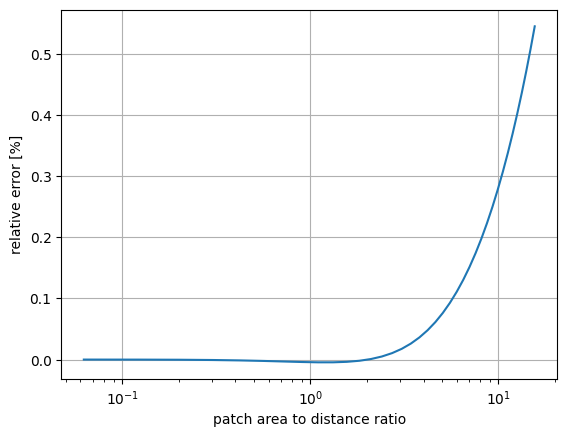

In [ ]:
figure = plt.figure()
plt.semilogx(heights**2,err_rel)
plt.xlabel('patch area to distance ratio')
plt.ylabel('relative error [%]')
plt.grid()
figure.show()

## Infinite diffuse plane

In [7]:
def run_energy_diff_specular_ratio(
        width, length, patch_size, source, receiver):
    """
    Calculate the ratio of diffuse to specular energy for an plane.
    The plane is located in the x-y plane. Its center is at (0, 0, 0).

    Parameters
    ----------
    width : float
        Width of the plane.
    length : float
        length of the plane.
    patch_size : float
        Size of the patches.
    source : pf.Coordinates
        Position of the source.
    receiver : pf.Coordinates
        Position of the receiver in cartesian.

    Returns
    -------
    ratio : float
        Ratio of diffuse to specular energy.
    """
    source_is = source.copy()
    source_is.z *= -1
    reflection_len =  (receiver - source_is).radius[0]
    speed_of_sound = 343
    sampling_rate = 1
    etc_duration = reflection_len/speed_of_sound
    etc_duration=1

    plane = sp.geometry.Polygon(
            [[-width/2, -length/2, 0],
             [width/2, -length/2, 0],
             [width/2, length/2, 0],
             [-width/2, length/2, 0]],
            [1, 0, 0], [0, 0, 1])

    #simulation parameters
    radi = sp.DirectionalRadiosityFast.from_polygon(
        [plane], patch_size)

    brdf_sources = pf.Coordinates(0, 0, 1, weights=1)
    brdf_receivers = pf.Coordinates(0, 0, 1, weights=1)
    brdf = sp.brdf.create_from_scattering(
        brdf_sources,
        brdf_receivers,
        pf.FrequencyData(1, [100]),
        pf.FrequencyData(0, [100]),
    )

    radi.set_wall_brdf(
        np.arange(1), brdf, brdf_sources, brdf_receivers)

    # set air absorption
    radi.set_air_attenuation(
        pf.FrequencyData(
            np.zeros_like(brdf.frequencies),
            brdf.frequencies))

    # initialize source energy at each patch
    radi.init_source_energy(source)

    # gather energy at receiver
    radi.calculate_energy_exchange(
        speed_of_sound=speed_of_sound,
        etc_time_resolution=1/sampling_rate,
        etc_duration=etc_duration,
        max_reflection_order=0)

    I_diffuse = radi.collect_energy_receiver_mono(receiver)

    I_specular = 1/(4*np.pi*reflection_len**2)
    return np.sum(I_diffuse.time)/I_specular

In [8]:
patch_size=.75
width = 40
depth = 40

In [9]:
# colocated s-r
source = pf.Coordinates(0, 0, 2, weights=1)
receiver = pf.Coordinates(0, 0, 2, weights=1)
ratio1 = run_energy_diff_specular_ratio(
    width, depth, patch_size, source, receiver)
err1=100*(ratio1-2)/2

print(f'Colocated s-r relative error: {err1:.1f}%')


Colocated s-r relative error: -1.7%


In [10]:
# same normal
source = pf.Coordinates(0, 0, 1, weights=1)
receiver = pf.Coordinates(0, 0, 2, weights=1)
ratio2 = run_energy_diff_specular_ratio(
    width, depth, patch_size, source, receiver)
err2=100*(ratio2-2)/2

print(f'On-normal s-r relative error: {err2:.1f}%')

KeyboardInterrupt: 

In [ ]:
theta = np.deg2rad(np.arange(20,90,5))
ratio3 = np.zeros_like(theta)

for i,th in enumerate(theta):
    source = pf.Coordinates.from_spherical_colatitude(
        0, th, 2, weights=1)
    receiver = pf.Coordinates.from_spherical_colatitude(
        np.pi, th, 2, weights=1)
    ratio3[i] = run_energy_diff_specular_ratio(
        width, depth, patch_size, source, receiver)

err3 = 100 * (ratio3-2*np.cos(theta)) / (2*np.cos(theta))

print('Same-height s-r relative error')
for i,e in enumerate(err3):
    print(f'    {np.rad2deg(theta[i]):.0f}º _____ {e:.1f}%')

Same-height s-r relative error
    20º _____ -1.3%
    25º _____ -1.0%
    30º _____ -0.7%
    35º _____ -0.3%
    40º _____ 0.0%
    45º _____ 0.4%
    50º _____ 0.8%
    55º _____ 1.2%
    60º _____ 1.6%
    65º _____ 1.9%
    70º _____ 2.2%
    75º _____ 2.5%
    80º _____ 2.5%
    85º _____ 0.0%
